# 3. Transfer Learning

## 3.1 Préparation des données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from time import time

%cd ..
import src.mytools as mt
%cd notebooks

2024-07-20 20:47:15.173958: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 20:47:15.234188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 20:47:15.234227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 20:47:15.235588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 20:47:15.244714: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 20:47:15.246091: I tensorflow/core/platform/cpu_feature_guard.cc:1

/home/chakir/Bureau/PROJETS/Projet6
/home/chakir/Bureau/PROJETS/Projet6/notebooks


/home/chakir/Bureau/PROJETS/Projet6/env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Chemin vers les dossiers 'train', 'validation' et 'test'
train_dir = '../data/train'
val_dir = '../data/validation'
test_dir = '../data/test'

class_names = os.listdir(val_dir)

In [3]:
# Fixation des sources des générateurs aléatoires pour assurer la reproductibilité des résultats.
seed_value = 42
set_random_seed(seed_value)

In [4]:
mlflow.set_tracking_uri("http://ec2-52-209-5-80.eu-west-1.compute.amazonaws.com:5000")
mlflow.set_experiment('projet6_transfer-learning')

<Experiment: artifact_location='s3://mlflow-cfikri/937544924322822054', creation_time=1721235473336, experiment_id='937544924322822054', last_update_time=1721235473336, lifecycle_stage='active', name='projet6_transfer-learning', tags={}>

Nous allons générer les données avec data augmentation comme dans le notebook précédent.

In [5]:
# Définition des générateurs de données

t_generator = ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.4,
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                )

generator = ImageDataGenerator(rescale=1./255)

train_generator = t_generator.flow_from_directory(train_dir,
                                                  target_size=(256, 256),
                                                  class_mode='categorical',
                                                  seed=seed_value
                                                 )

val_generator = generator.flow_from_directory(val_dir,
                                              target_size=(256, 256),
                                              class_mode='categorical',
                                              shuffle=False,
                                              seed=seed_value
                                             )

Found 288 images belonging to 3 classes.


Found 72 images belonging to 3 classes.


## 3.2 Modèle avec base VGG16

Pour commencer, nous allons créer un modèle en prenant comme base un VGG16 sans inclure les couches denses de classification et en fixant les paramètres des couches convolutionnelles. En effet, notre dataset d'entraînement et trop petit pour qu'il soit utile d'entraîner des couches convolutionnelles.

In [6]:
# Chargement du modèle VGG16 pré-entraîné sans les couches supérieures
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Fixation des couches de base du modèle VGG16 pour ne pas les réentraîner
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Ajouter vos propres couches de classification
model = Sequential([base_model,
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')
                   ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 31493955 (120.14 MB)
Trainable params: 16779267 (64.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
history, temps_execution = mt.compile_and_train(model, 
                                                train_generator, 
                                                val_generator, 
                                                optimizer=Nadam,
                                                metrics=['accuracy', Precision(), Recall(), AUC()], 
                                                epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Compilation réussie.
Epoch 1/100


2024-07-20 18:51:02.421541: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-20 18:51:02.633977: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


1/9 [==>...........................] - ETA: 1:19 - loss: 1.3559 - accuracy: 0.3438 - precision: 0.3438 - recall: 0.3438 - auc: 0.5674

2024-07-20 18:51:09.764967: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.
2024-07-20 18:51:09.954353: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


2/9 [=====>........................] - ETA: 50s - loss: 17.3435 - accuracy: 0.2656 - precision: 0.2656 - recall: 0.2656 - auc: 0.4348

2024-07-20 18:51:16.962157: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


9/9 [==============================] - 84s 9s/step - loss: 8.7842 - accuracy: 0.3993 - precision: 0.4014 - recall: 0.3958 - auc: 0.5511 - val_loss: 1.7251 - val_accuracy: 0.5139 - val_precision: 0.5139 - val_recall: 0.5139 - val_auc: 0.7028 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 85s 10s/step - loss: 2.6871 - accuracy: 0.4062 - precision: 0.3986 - recall: 0.3889 - auc: 0.5829 - val_loss: 2.2102 - val_accuracy: 0.3889 - val_precision: 0.3913 - val_recall: 0.3750 - val_auc: 0.6563 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 85s 10s/step - loss: 1.1651 - accuracy: 0.5833 - precision: 0.6084 - recall: 0.5556 - auc: 0.7698 - val_loss: 0.5216 - val_accuracy: 0.8056 - val_precision: 0.8088 - val_recall: 0.7639 - val_auc: 0.9259 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 85s 10s/step - loss: 0.7709 - accuracy: 0.7153 - precision: 0.7266 - recall: 0.6736 - auc: 0.8607 - val_loss: 0.4101 - val_accuracy: 0.8194 - val_precision: 0.85

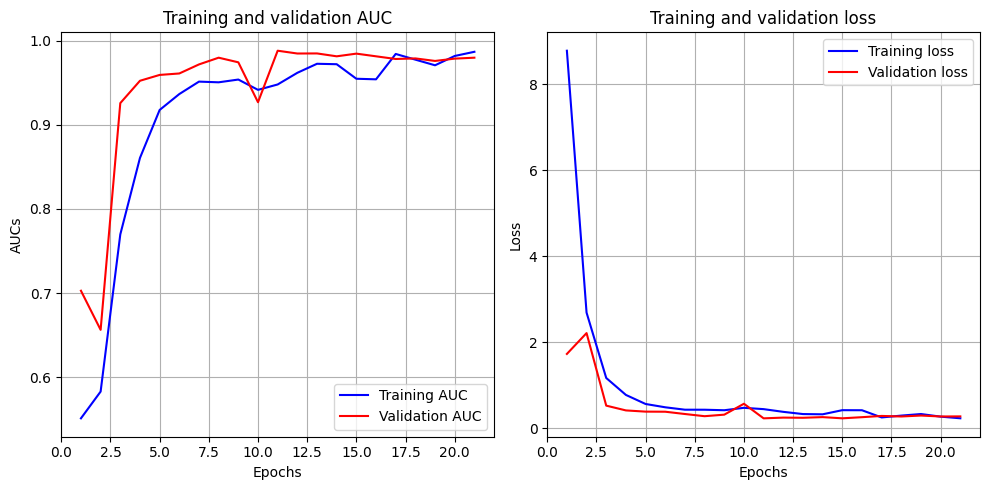

In [10]:
mt.graphique_auc_perte(history, 'VGG16')

3/3 [==============================] - 13s 4s/step


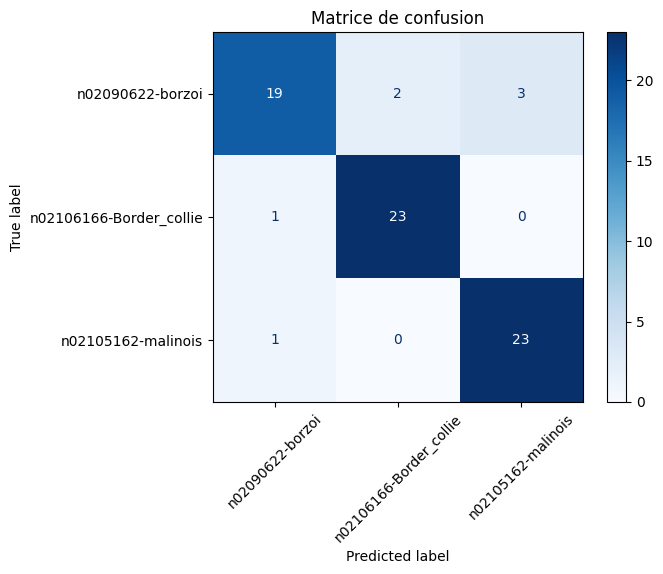

In [11]:
mt.matrice_confusion(model, 'VGG16', val_generator, class_names)

In [27]:
params = {'algorithme' : 'VGG16',  
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'VGG16'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_VGG16.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_VGG16.png'}

mt.log_mlflow_run('VGG16_transfer_learning', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='VGG16')

2024/07/17 19:57:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/chakir/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## 3.3 Modèle avec base InceptionV3

In [6]:
# Charger le modèle InceptionV3 pré-entraîné sans les couches supérieures
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Geler les couches de base du modèle InceptionV3 pour ne pas les entraîner
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Ajout des couches de classification
model = Sequential([base_model,
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(3, activation='softmax')
                   ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 59553571 (227.18 MB)
Trainable params: 37750787 (144.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [9]:
history, temps_execution = mt.compile_and_train(model, 
                                                train_generator, 
                                                val_generator, 
                                                optimizer=Nadam,
                                                metrics=['accuracy', Precision(), Recall(), AUC()], 
                                                epochs=100)
print(f"durée d'exécution : {temps_execution} min")

Compilation réussie.
Epoch 1/100
9/9 [==============================] - 35s 3s/step - loss: 23.6048 - accuracy: 0.7014 - precision: 0.7107 - recall: 0.6910 - auc: 0.8220 - val_loss: 0.4827 - val_accuracy: 0.9861 - val_precision: 0.9861 - val_recall: 0.9861 - val_auc: 0.9896 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 28s 3s/step - loss: 0.3438 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9919 - val_loss: 0.2656 - val_accuracy: 0.9861 - val_precision: 0.9861 - val_recall: 0.9861 - val_auc: 0.9896 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 28s 3s/step - loss: 0.4302 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9840 - val_loss: 0.4393 - val_accuracy: 0.9861 - val_precision: 0.9861 - val_recall: 0.9861 - val_auc: 0.9896 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 26s 3s/step - loss: 0.4463 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9815 - val_loss: 1.3585 - val_accurac

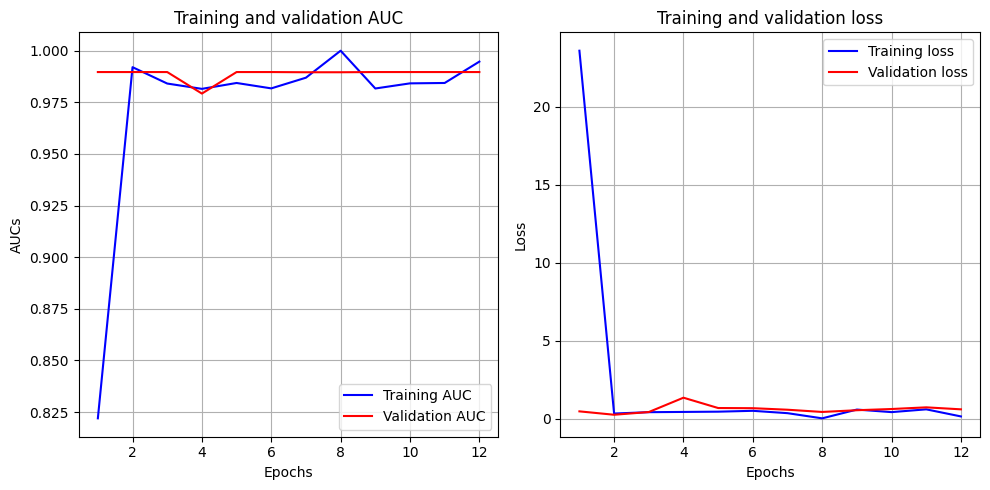

In [10]:
mt.graphique_auc_perte(history, 'InceptionV3')

3/3 [==============================] - 7s 1s/step


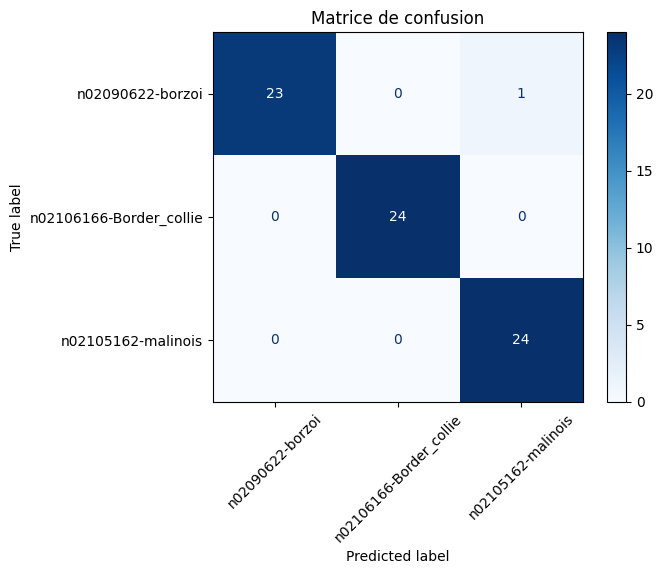

In [11]:
mt.matrice_confusion(model, 'InceptionV3', val_generator, class_names)

In [14]:
params = {'algorithme' : 'InceptionV3',  
          'optimizer' : 'Nadam', 
          'fonction_perte' : 'categorical_crossentropy',
          'learning_rate' : 0.001,
          'nbr_epoques' : 100}

metrics = {'accuracy' : max(history.history['val_accuracy']),
           'precision' : max(history.history['val_precision']),
           'recall' : max(history.history['val_recall']),
           'auc-roc' : max(history.history['val_auc'])}

tags = {'Dataset' : 'Stanford Dogs Dataset', 'algorithme' : 'InceptionV3'}

artifacts = {"Evolution du AUC-ROC et de l'entropie croisée au cours des époques" : '../outputs/courbes_performances_InceptionV3.png',
             'Matrice de confusion' : '../outputs/matrice_confusion_InceptionV3.png'}

mt.log_mlflow_run('InceptionV3_transfer_learning', 
                  params, 
                  metrics, 
                  tags=tags, 
                  artifacts=artifacts,
                  model=model,
                  model_type='tensorflow',
                  model_name='InceptionV3')

2024/07/20 20:54:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpqrlzg529/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqrlzg529/model/data/model/assets


In [12]:
test_generator = generator.flow_from_directory(test_dir,
                                               target_size=(256, 256),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed_value
                                              )

Found 91 images belonging to 3 classes.


3/3 [==============================] - 5s 2s/step


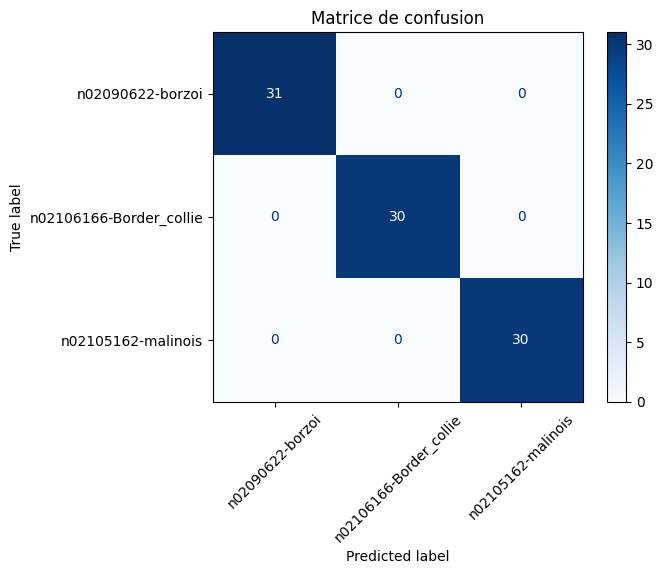

In [13]:
mt.matrice_confusion(model, 'InceptionV3_test', test_generator, class_names)